In [1]:
! pip install transformers tensorboardX

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [3]:
DATA_PATH = './dataset/'
PROJECT_DIR = './'

In [4]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
column_names = ['id', 'movie_name', 'genre', 'description']
dataframe = pd.read_csv(DATA_PATH+'/train_data.txt', delimiter=':::', names=column_names)

/var/folders/2l/l_lnhh8n4y3c6tw0v92pbxf80000gn/T/ipykernel_10343/1723410171.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dataframe = pd.read_csv(DATA_PATH+'/train_data.txt', delimiter=':::', names=column_names)


In [6]:
genre_col = dataframe['genre']

dataframe = dataframe.drop(['genre', 'id'], axis=1)
dataframe['genre'] = genre_col

In [7]:
dataframe

,movie_name,description,genre
0,Oscar et la dame rose (2009),Listening in to a conversation between his do...,drama
1,Cupid (1997),A brother and sister with a past incestuous r...,thriller
2,"Young, Wild and Wonderful (1980)",As the bus empties the students for their fie...,adult
3,The Secret Sin (1915),To help their unemployed father make ends mee...,drama
4,The Unrecovered (2007),The film's title refers not only to the un-re...,drama
...,...,...,...
54209,"""Bonino"" (1953)",This short-lived NBC live sitcom centered on ...,comedy
54210,Dead Girls Don't Cry (????),The NEXT Generation of EXPLOITATION. The sist...,horror
54211,Ronald Goedemondt: Ze bestaan echt (2008),"Ze bestaan echt, is a stand-up comedy about g...",documentary
54212,Make Your Own Bed (1944),Walter and Vivian live in the country and hav...,comedy


### Exploratory Data Analysis

/var/folders/2l/l_lnhh8n4y3c6tw0v92pbxf80000gn/T/ipykernel_10343/3491894337.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='genre', data=dataframe, palette='crest')


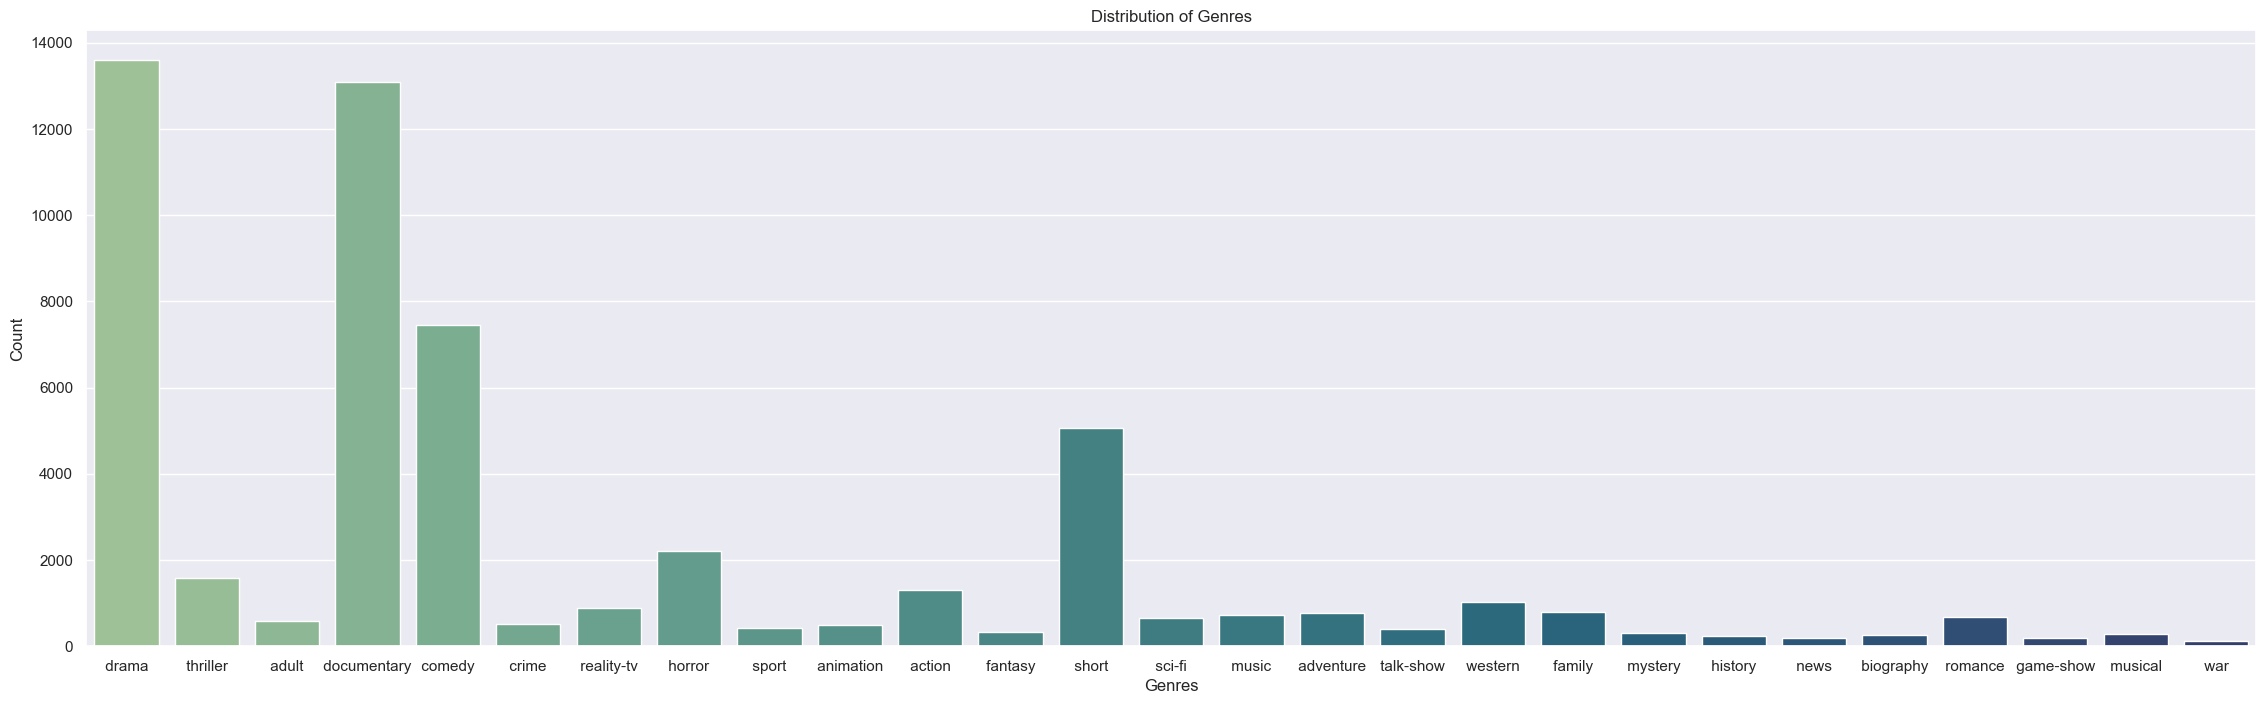

In [8]:
sns.set(style="darkgrid")
plt.figure(figsize=(28, 8))
sns.countplot(x='genre', data=dataframe, palette='crest')
plt.title('Distribution of Genres')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.show()

In [9]:
top_10_categories = dataframe['genre'].value_counts().head(10).index.tolist()
dataframe = dataframe[dataframe['genre'].isin(top_10_categories)]

/var/folders/2l/l_lnhh8n4y3c6tw0v92pbxf80000gn/T/ipykernel_10343/3597019316.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='genre', data=dataframe, palette='crest')


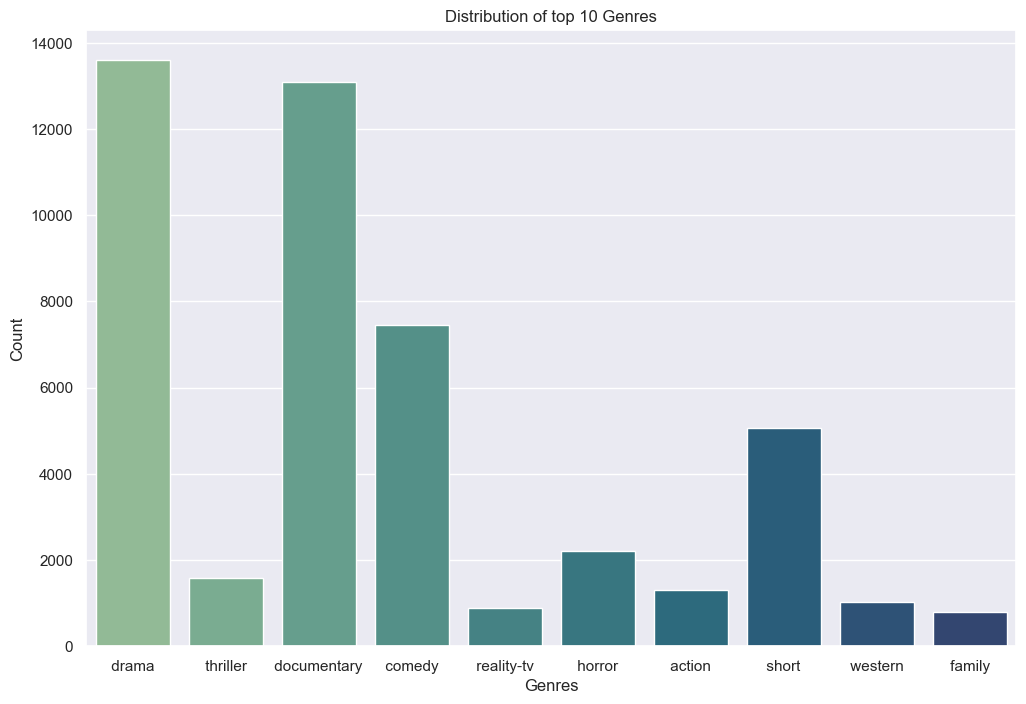

In [10]:
sns.set(style="darkgrid")
plt.figure(figsize=(12, 8))
sns.countplot(x='genre', data=dataframe, palette='crest')
plt.title('Distribution of top 10 Genres')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.show()

In [14]:
dataframe["Words Per description"] = dataframe["description"].str.split().apply(len)

/var/folders/2l/l_lnhh8n4y3c6tw0v92pbxf80000gn/T/ipykernel_10343/2523989113.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["Words Per description"] = dataframe["description"].str.split().apply(len)


<Axes: title={'center': 'Words Per description'}, xlabel='genre'>

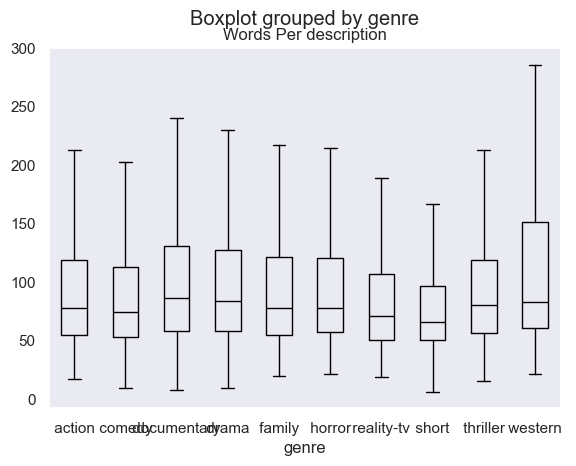

In [17]:
dataframe.boxplot("Words Per description", by="genre", grid=False,
              showfliers=False, color="black")

## Transformer from scratch

In [86]:
import numpy as np

In [87]:
class InputEmbedding(nn.Module):
    def __init__(self, model_dim, vocab_size):
        super().__init__()
        self.model_dim = model_dim
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, model_dim)

    def forward(self, x):
        return self.embedding(x) * np.sqrt(self.model_dim)

In [88]:
class PositionalEmbedding(nn.Module):
    def __init__(self, model_dim, seq_len, dropout):
        super().__init__()
        self.model_dim = model_dim
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)

        pos_embed = torch.zeros(seq_len, model_dim)
        positions = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        denom = torch.exp(torch.arange(0, model_dim, 2, dtype=torch.float)*(np.log(10000.0)/model_dim))

        pos_embed[:, 0::2] = torch.sin(positions * denom)
        pos_embed[:, 1::2] = torch.cos(positions * denom)

        pos_embed = pos_embed.unsqueeze(0) # (1, seq_len, model_dim)

        self.register_buffer('pos_embed', pos_embed)

    def forward(self, x):
        x = x + (self.pos_embed[:, :x.shape[1], :]).requires_grad_(False)
        return self.dropout(x)

In [89]:
class LayerNormalization(nn.Module):
    def __init__(self, eps = 10**-6):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(1)) # Multiplicative
        self.beta =  nn.Parameter(torch.zeros(1)) # Additive

    def forward(self, x):
        # x is (batch_size, seq_len, embed_dim)
        mean = x.mean(dim = -1, keepdim = True)
        std = x.std(dim = -1, keepdim = True)
        return self.gamma * (x-mean)/(std+self.eps) + self.beta

In [90]:
class FeedForward(nn.Module):
    def __init__(self, model_dim, out_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(model_dim, out_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(out_dim, model_dim)

    def forward(self, x):
        # (batch, seq_len, embed_dim) -> (batch, seq_len, out_dim) -> (batch, seq_len, embed_dim)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [91]:
class MultiHeadAttention(nn.Module):
    def __init__(self, model_dim, num_heads, dropout):
        super().__init__()
        self.model_dim = model_dim
        self.heads = num_heads
        assert model_dim % num_heads == 0, "Embedding dimension is not divisible by number of heads"

        self.head_dim = model_dim//num_heads

        self.w_q = nn.Linear(model_dim, model_dim)
        self.w_k = nn.Linear(model_dim, model_dim)
        self.w_v = nn.Linear(model_dim, model_dim)

        self.w_o = nn.Linear(model_dim, model_dim)
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        head_dim = query.shape[-1]

        # Matrix multiplication of
        # (batch, num_heads, seq_len, head_dim) x (batch, num_heads, head_dim, seq_len) --> (batch, num_heads, seq_len, seq_len)

        attention_scores = (query @ key.transpose(-2, -1))/np.sqrt(head_dim)

        if mask is not None:
            expanded_mask = mask.unsqueeze(1).unsqueeze(2).expand_as(attention_scores)
            attention_scores.masked_fill_(expanded_mask == 0, -1e9)

        attention_scores = attention_scores.softmax(dim = -1) #(batch, num_heads, seq_len, seq_len)

        if dropout is not None:
            attention_scores = dropout(attention_scores)

        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v, mask):
        # (batch, seq_l, embed_dim)
        query = self.w_q(q)
        key = self.w_k(k)
        value = self.w_v(v)

        # (batch, seq_len, embed_dim) -> (batch, seq_len, num_heads, head_dim) -> (batch, num_heads, seq_len, head_dim)
        query = query.view(query.shape[0], query.shape[1], self.heads, self.head_dim).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.heads, self.head_dim).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.heads, self.head_dim).transpose(1, 2)

        x, self.attention_scores = MultiHeadAttention.attention(query, key, value, mask, self.dropout)

        # (batch, num_heads, seq_len, head_dim) -> (batch, seq_len, num_heads, head_dim) -> (batch, seq_len, embed_dim)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.heads*self.head_dim)

        # (batch, seq_len, embed_dim) -> (batch, seq_len, embed_dim)
        return self.w_o(x)

In [92]:
class ResidualConnection(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNormalization()

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

In [93]:
class EncoderBlock(nn.Module):
    def __init__(self, self_attention_block: MultiHeadAttention, feed_forward: FeedForward, dropout: float):
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(2)])

    def forward(self, x, src_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x

In [94]:
class Encoder(nn.Module):
    def __init__(self, layers: nn.ModuleList):
        super().__init__()
        self.layers = layers
        self.layer_norm = LayerNormalization()

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.layer_norm(x)

In [95]:
class ProjectionLayer(nn.Module):
    def __init__(self, embed_dim, vocab_size):
        super().__init__()
        self.fc = nn.Linear(embed_dim, vocab_size)

In [96]:
import torch.nn.functional as F

class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim) -> None:
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x

In [97]:
class Model(nn.Module):
    def __init__(self,
                 input_embedding: InputEmbedding,
                 pos_embedding: PositionalEmbedding,
                 encoder: Encoder,
                 mlp: MultiLayerPerceptron,
                 ):
        super().__init__()
        self.encoder = encoder
        self.input_embedding = input_embedding
        self.position_embedding = pos_embedding
        self.mlp = mlp

    def forward(self, x, attention_mask):
        x = self.input_embedding(x)
        x = self.position_embedding(x)
        x = self.encoder(x, attention_mask)
        x = self.mlp(x[:, 0])
        return x

In [98]:
from transformers import BertTokenizer
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import OneHotEncoder
import json

In [99]:
class MyDataset(Dataset):
    def __init__(self, tokenized_texts, encoded_labels):
        self.tokenized_texts = tokenized_texts
        self.encoded_labels = encoded_labels

    def __len__(self):
        return len(self.tokenized_texts["input_ids"])

    def __getitem__(self, idx):
        return {
            "input_ids": self.tokenized_texts["input_ids"][idx],
            "attention_mask": self.tokenized_texts["attention_mask"][idx],
            "labels": torch.tensor(self.encoded_labels[idx], dtype=torch.float32),
        }

In [100]:
def prepare_data(input_list, labels, label_encoder, config):

    meta_data = {}

    if config["tokenizer"] == 'bert_tokenizer':
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        meta_data['vocab_size'] = tokenizer.vocab_size
    else:
        raise Exception("Unknown Tokenizer")

    encoded_labels = label_encoder.fit_transform(labels)

    tokenized_texts = tokenizer(input_list, padding='max_length', truncation=True,
                                max_length=config["seq_len"], return_tensors='pt',
                                return_attention_mask='True')

    dataset = MyDataset(tokenized_texts, encoded_labels)
    dataloader = DataLoader(dataset, batch_size= config['batch_size'], shuffle=True)
    return dataloader, meta_data

In [115]:
import json

with open('/content/drive/MyDrive/Colab Projects/transformer_scratch/config.json', 'r') as json_file:
    config = json.load(json_file)

In [117]:
from pathlib import Path

def get_weights_path(config, epoch):
    model_base = config["model_basename"]
    file_name = f'{model_base}epoch{epoch}.pth'
    return str(Path('.')/file_name)

In [118]:
get_weights_path(config, 10)

'model_epoch10.pth'

In [119]:
def build_model(vocab_size, seq_len,
                num_classes,
                embed_dim=512, num_heads = 8,
                num_encoders = 6,
                dropout = 0.1, encoder_ff_out_dim = 2048) -> Model:
    inp_embedding = InputEmbedding(embed_dim, vocab_size)
    pos_embedding = PositionalEmbedding(embed_dim, seq_len, dropout)

    encoder_blocks = []
    for _ in range(num_encoders):
        self_attention_block = MultiHeadAttention(embed_dim, num_heads, dropout)
        feed_forward = FeedForward(embed_dim, encoder_ff_out_dim, dropout)
        encoder_blocks.append(EncoderBlock(self_attention_block, feed_forward, dropout))

    encoder = Encoder(nn.ModuleList(encoder_blocks))

    mlp = MultiLayerPerceptron(embed_dim, 512, num_classes)

    return Model(inp_embedding, pos_embedding, encoder, mlp)


In [105]:
input_list = dataframe['description'].tolist()
label_list = [[label] for label in dataframe['genre']]
label_encoder = OneHotEncoder(sparse=False)

dataloader, meta_data = prepare_data(input_list, label_list, label_encoder, config)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [127]:
import torch.optim as optim
from tensorboardX import SummaryWriter
import os

def train(config):
    torch.cuda.empty_cache()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device {device}')

    writer = SummaryWriter()

    # input_list = dataframe['description'].tolist()
    # label_list = [[label] for label in dataframe['genre']]
    # label_encoder = OneHotEncoder(sparse=False)

    # dataloader, meta_data = prepare_data(input_list, label_list, label_encoder, config)

    print(config)
    model = build_model(
        meta_data['vocab_size'],
        config['seq_len'],
        config['num_classes'],
        config['embed_dim']
        )

    model = model.to(device)

    print(f"Model has {sum(p.numel() for p in model.parameters())}")

    checkpoint_dir = PROJECT_DIR+config['model_folder']
    # os.makedirs(checkpoint_dir, exist_ok=True)

    should_preload = config['preload']
    if should_preload:
        checkpoint_filename = get_weights_path(config, config['preload_epoch'])
        checkpoint = torch.load(checkpoint_dir+"/"+checkpoint_filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Loaded model weights!")

    NUM_EPOCHS = config['epochs']
    lr = config['learning_rate']
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(NUM_EPOCHS):
        model.train()

        total_loss = 0.0
        total_correct = 0

        for batch in dataloader:
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]
            labels = batch["labels"]

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            label_indices = torch.argmax(labels, dim=1)

            outputs = model(input_ids, attention_mask)

            loss = criterion(outputs, label_indices)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)

            total_correct += (predicted == label_indices).sum().item()

            total_loss += loss.item()

        average_loss = total_loss / len(dataloader)
        accuracy = total_correct / len(dataloader.dataset)

        print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}]")
        print(f"Loss: {average_loss:.4f}, Accuracy: {accuracy * 100:.2f}%")

        checkpoint_filename = os.path.join(checkpoint_dir, f'model_epoch{epoch+1}.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
        }, checkpoint_filename)

        writer.add_scalar("Training Loss", average_loss, epoch)
        writer.add_scalar("Training Accuracy", accuracy, epoch)

    writer.close()

In [128]:
train(config=config)

Using device cuda
{'batch_size': 128, 'learning_rate': 0.0002, 'seq_len': 512, 'epochs': 10, 'num_classes': 10, 'embed_dim': 512, 'tokenizer': 'bert_tokenizer', 'model_folder': 'weights', 'model_basename': 'model_', 'preload': 'True', 'preload_epoch': 10}
Model has 34797092
Loaded model weights!
Epoch [1/10]
Loss: 1.8838, Accuracy: 57.58%
Epoch [2/10]
Loss: 1.8800, Accuracy: 57.98%
Epoch [3/10]
Loss: 1.8760, Accuracy: 58.37%
Epoch [4/10]
Loss: 1.8716, Accuracy: 58.82%
Epoch [5/10]
Loss: 1.8683, Accuracy: 59.21%


KeyboardInterrupt: ignored